import

In [1]:
import numpy as np
import pandas as pd
import math
import csv 

import torch
import torch.nn as nn
from torch.autograd import Variable as V
from torch.utils.data import DataLoader,Dataset,TensorDataset
 
import matplotlib.pyplot as plt          

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

from tqdm import tqdm

get x-data

In [2]:
data_train = np.load('data/train.npy', allow_pickle=True)
data_test = np.load('data/test.npy', allow_pickle=True)

In [3]:
data_train = np.delete(data_train, -1, axis=1)
data_test = np.delete(data_test, -1, axis=1)

get y-data

In [4]:
y_test = np.load('data/y_test.npy', allow_pickle=True)
y_train = np.load('data/y_train.npy', allow_pickle=True)

In [5]:
n,m = y_test.shape
for i in range(n):
    if y_test[i][0] == 'normal.':
        y_test[i][0] = int(1)
    else:
        y_test[i][0] = int(0)
    
n,m = y_train.shape
for i in range(n):
    if y_train[i][0] == 'normal.':
        y_train[i][0] = int(1)
    else:
        y_train[i][0] = int(0)


encoder data loader

In [6]:
def data_loader(x, y):
    MMScaler = MinMaxScaler()
    x = MMScaler.fit_transform(x)
    tensor_x = torch.from_numpy(x.astype(np.float32))
    tensor_y = torch.from_numpy(y.astype(np.float32))

    dataset = TensorDataset(tensor_x, tensor_y)
    dataset_loader = DataLoader(dataset, batch_size=4096, shuffle=False)
    return dataset_loader

In [98]:
# x = data_train
# y = y_train
# Y = y

encoder build

In [7]:
class autoencoder(nn.Module):                    
    def __init__(self, k):                         
        super(autoencoder,self).__init__()       
        self.encoder = nn.Sequential(             
            nn.Linear(41, 8),                    
            nn.Tanh(),                          
            nn.Linear(8, k),                    
        )                                       
        self.decoder=nn.Sequential(             
            nn.Linear(k, 4),                    
            nn.Tanh(),                          
            nn.Linear(4, 41),                    
            nn.Sigmoid()                        
        )                                       
                                                
    def forward(self, x):                       
        encoder = self.encoder(x)                 
        decoder = self.decoder(encoder)           
        return encoder,decoder                                                        

In [8]:
def init(k):
    model = autoencoder(k)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    return model, criterion, optimizer

In [10]:
def train(model, criterion, optimizer, dataset_loader, epoch_num = 300):
    for epoch in range(epoch_num):
        total_loss = 0
        for i ,(x,y) in enumerate(tqdm(dataset_loader)):
            _, pred = model(V(x))
            print(pred.shape, x.shape)
            loss = criterion(pred,x)
            print(loss.shape)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss
        if epoch % 5 == 0:
            print(epoch, ":", total_loss.data.numpy())
    return model

In [11]:
def draw(model, dataset, Y):
    x_=[]                                     
    y_=[]                                     
    for i, (x, y) in enumerate(tqdm(dataset)):   
        _, pred = model(V(x))            # 这里的model为训练好的autoencoder模型               
        #loss = criterion(pred, x)            
        dimension = _.data.numpy()              
        x_.append(dimension[0])               
        y_.append(dimension[1])     
    
    plt.scatter(np.array(x_), np.array(y_), c=Y)   
    for i in tqdm(range(len(np.array(x_)))):     
        plt.annotate(i,(x_[i], y_[i]))         
    plt.show()       

In [12]:
def save_model(model, name, name1):
    torch.save(model, name)
    torch.save(model, name1)
    # 读取
    # model = torch.load(PATH)  

get encode

In [13]:
def get_encode(model, dataset_loader, name):
    reduced_x = torch.tensor(np.ones((0, 0)))
    print(reduced_x)

    for i ,(x, y) in enumerate(tqdm(dataset_loader)):
        if i > 1:
            break
        encoder, decoder = model(V(x))
        reduced_x = encoder

    for i ,(x, y) in enumerate(tqdm(dataset_loader)):
        if i == 0:
            continue
        encoder, decoder = model(V(x))
        reduced_x = torch.cat([reduced_x, encoder], dim=0) 
    
    print(reduced_x.shape)

    x2 = torch.detach(reduced_x).numpy()
    # np.save('data/encoder_X2.npy', x2)
    # np.save('data/encoder_Y2.npy', test_x2)
    np.save(name, x2)
    return x2

In [14]:
dataloader = data_loader(data_train, y_train)
testdata_loader = data_loader(data_test, y_test)

In [15]:
def run(k, name, name1, epoch):
    model, criterion, optimizer = init(k)
    model = train(model, criterion, optimizer, dataloader, epoch)
    get_encode(model, dataloader, name)
    get_encode(model, testdata_loader, name1)
    return model

In [ ]:
model1 = run(1, 'data/encoder_X1.npy', 'data/encoder_Y1.npy', 80)

In [117]:
save_model(model1, 'model1', 'model1.pt')

In [ ]:
model5 = run(5, 'data/encoder_X5.npy', 'data/encoder_Y5.npy', 100)
save_model(model5, 'model5', 'model5.pt')

In [ ]:
model2 = run(2, 'data/encoder_X2.npy', 'data/encoder_Y2.npy', 100)
save_model(model2, 'model2', 'model2.pt')

In [17]:
x2_data = np.load('data/encoder_X2.npy', allow_pickle = True)

In [34]:
def draw2(x, y):
    n, m = x.shape
    x1, y1 = [], []
    x2, y2 = [], []
    for i in tqdm(range(n)):
        if y[i, 0] == 0:
            if x[i, 0] > 10000 or x[i, 1] > 10000:
                continue
            # print(0, x[i, 0], x[i, 1])
            x1.append(x[i, 0]/100.0)
            y1.append(x[i, 1]/100.0)
        elif y[i, 0] == 1:
            if x[i, 0] > 10000 or x[i, 1] > 10000:
                continue
            # print(1, x[i, 0], x[i, 1])
            x2.append(x[i, 0]/100.0)
            y2.append(x[i, 1]/100.0)

    # plt.scatter(np.array(x1), np.array(y1), c='red')   
    plt.scatter(np.array(x2), np.array(y2), c='yellow')   

    plt.show()

[[-6.189362  -2.6149657]
 [-6.1487465 -2.6174405]
 [-6.1081448 -2.6199112]
 ...
 [-8.008648  -2.50593  ]
 [-7.939379  -2.5095694]
 [-7.9552646 -2.506543 ]]


100%|██████████| 3919781/3919781 [00:14<00:00, 272072.21it/s]


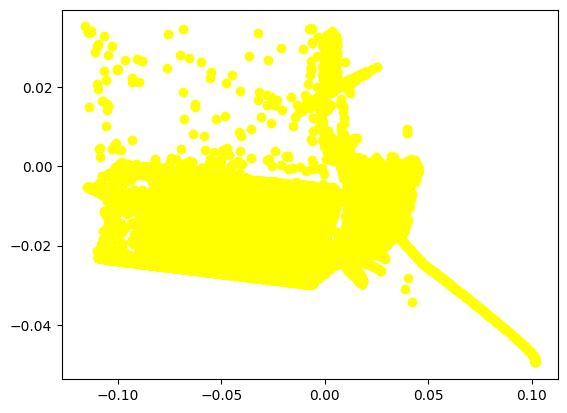

In [28]:
draw2(x2_data, y_train)

100%|██████████| 3919781/3919781 [00:14<00:00, 271539.63it/s]


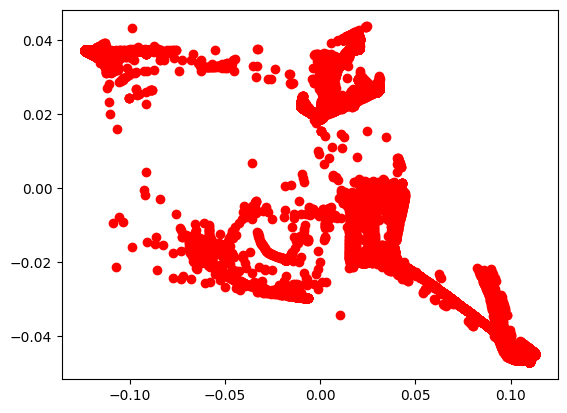

In [30]:
draw2(x2_data, y_train)

In [7]:
pca_x2 = np.load('data/X_2.npy', allow_pickle = True)

In [25]:
print(pca_x2)
print(y_train[0])
print(pca_x2.shape)
print(y_train.shape)

[[-1529.95831155 43874.62011229]
 [-1544.48362371   830.61835893]
 [-1539.65182985  -715.3857347 ]
 ...
 [-1559.84079407  -965.37061456]
 [-1558.29130053  2408.62917496]
 [-1559.18943012  -103.3708375 ]]
[1]
(3919781, 2)
(3919781, 1)


100%|██████████| 3919781/3919781 [00:02<00:00, 1765720.38it/s]


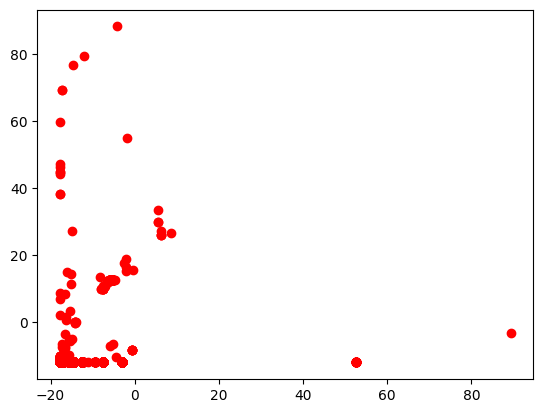

In [32]:
draw2(pca_x2, y_train)

100%|██████████| 3919781/3919781 [00:02<00:00, 1760914.26it/s]


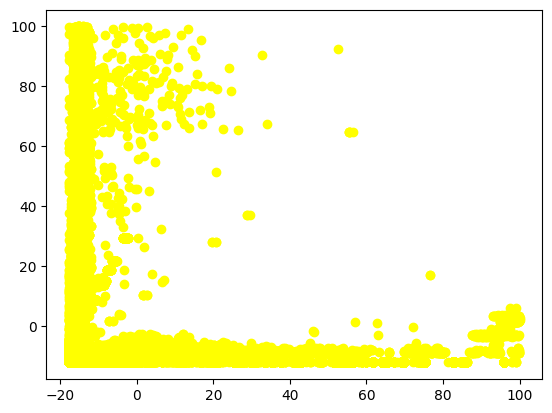

In [35]:
draw2(pca_x2, y_train)